# Assignment11
* 2019220177 Seungwook

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My\ Drive/MIMP

/content/drive/My Drive/MIMP


## Initial Setting

### git Setting

In [ ]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   Assignment11/Assignment11.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git config --global user.email "sooonchang@gmail.com"
!git config --global user.name "SooonChang"

In [ ]:
!git add .
!git commit -m "Assignment11: Define Classifier"

[master 989d105] Assignment11: Define Classifier
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Assignment11/Assignment11.ipynb (96%)


In [ ]:
!git push origin master

Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 6.09 KiB | 1.22 MiB/s, done.
Total 4 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/SooonChang/MIMP
   a75abd4..989d105  master -> master


## 0. Optimization

### Import libraries

In [ ]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from collections import OrderedDict

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
review_data = load_files(r"Assignment11/movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()
 
for sen in range(0, len(X)):
  # remove all the special characters
  document = re.sub(r'\W', ' ',str(X[sen]))

  # remove all single characters
  document = re.sub(r'\s+[a-zA-Z]\s+',' ', document)

  # remove single characters from the start
  document = re.sub(r'\^[a-zA-Z]\s+',' ',document)

  # substituting multiple spaces with single space
  document = re.sub(r'\s+', ' ',document, flags=re.I)

  # Removing prefixed 'b'
  document = re.sub(r'^b\s+','',document)

  # Converting to Lowercase
  document = document.lower()

  # Lemmatization
  document = document.split()
  document = [stemmer.lemmatize(word) for word in document]
  document = ' '.join(document)

  documents.append(document)

In [ ]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=False)

In [ ]:

def sigmoid(x):
  return 1/ (1 + np.exp(-x))

class Sigmoid():
  
  def __init__(self):
    self.out = None
  
  def forward(self, x):
    out = sigmoid(x)
    self.out = out
    return out
  
  def backward(self, dout): # s' = (1-s)*s
    dx = dout*(1.0 - self.out) * self.out

    return dx

class Layer():
  def __init__(self,W,b):
    self.W = W
    self.b = b

    self.x = None
    self.x_shape = None
    # differntial
    self.dW = None
    self.db = None

  def forward(self, x):
    self.x_shape = x.shape
    x = x.reshape(x.shape[0],-1)
    self.x = x

    out = np.dot(self.x,self.W) + self.b

    return out
  
  def backward(self,dout):
    dx = np.dot(dout,self.W.T)
    self.dW = np.dot(self.x.T,dout)
    self.db = np.sum(dout, axis=0)

    dx = dx.reshape(*self.x_shape)
    return dx

class object_func():
  def __init__(self):
    self.loss = None
    self.h = None
    self.t = None

  def forward(self, y, t):
    self.t = t
    self.h = sigmoid(y)
    m = t.shape[0]
    self.loss = np.sum(-t*np.log(self.h +1e-7) -(1-t)*np.log(1-self.h +1e-7)) / m

    return self.loss
  
  def backward(self, dout=1):
    m = self.t.shape[0]
    dx = (self.h - self.t)/m
    
    return dx

In [ ]:
class Classifier():

  def __init__(self, input_size, hidden_size_list, output_size,
               std = 0.01, weight_decay_lambda = 0.01):
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size_list = hidden_size_list
    self.hidden_layer_num = len(hidden_size_list)
    self.weight_decay_lambda = weight_decay_lambda
    self.params = {}

    self.__init_weight(std)
    
    self.layers = OrderedDict()
    for idx in range(1, self.hidden_layer_num +1):
      self.layers['Layer'+str(idx)] = Layer(self.params['W' + str(idx)],
                                            self.params['b'+ str(idx)])
      self.layers['Sigmoid' + str(idx)] = Sigmoid()
    idx = self.hidden_layer_num+1
    self.layers['Layer' + str(idx)] = Layer(self.params['W' + str(idx)],
                                            self.params['b' + str(idx)])
    self.last_layer = object_func()
  
  def __init_weight(self, std):

    all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
    for idx in range(1, len(all_size_list)):
      self.params['W' + str(idx)] = std*np.random.randn(all_size_list[idx-1], all_size_list[idx])
      self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)
    
    return x
  
  def loss(self, x, t):
    y = self.predict(x)
    weight_decay = 0
    for idx in range(1, self.hidden_layer_num + 2):
      W = self.params['W' + str(idx)]
      weight_decay += 0.5* self.weight_decay_lambda*np.sum(W **2)
    
    return self.last_layer.forward(y, t) + weight_decay
  
  def accuracy(self,x, t):
    y = self.predict(x)
    y = np.round(sigmoid(y))

    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy

  
  def gradient(self, x, t):

    # forward
    self.loss(x, t)
    dout = 1
    dout = self.last_layer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)
      
    grads = {}
    for idx in range(1, self.hidden_layer_num + 2):
      grads['W' + str(idx)] = self.layers['Layer' + str(idx)].dW + self.weight_decay_lambda * self.layers['Layer' + str(idx)].W
      grads['b' + str(idx)] = self.layers['Layer' + str(idx)].db
    
    return grads


In [ ]:
class SGD:
  def __init__(self, lr = 0.01):
    self.lr = lr
  
  def update(self, params, grads):
    for key in params.keys():
      params[key] -= self.lr * grads[key]

In [26]:
clf = Classifier(input_size=1500, hidden_size_list=[200 ,100, 100, 50], output_size=1)
optimizer = SGD(lr = 0.05)

In [27]:
num_iteration = 5000

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []


In [28]:
y_train = np.reshape(y_train,[-1,1])
y_test = np.reshape(y_test, [-1, 1])

In [29]:
for i in range(num_iteration):

  grads = clf.gradient(X_train, y_train)
  optimizer.update(clf.params, grads)

  train_loss = clf.loss(X_train,y_train)
  train_loss_list.append(train_loss)
  test_loss = clf.loss(X_test,y_test)
  test_loss_list.append(test_loss)

  train_acc = clf.accuracy(X_train, y_train)
  test_acc = clf.accuracy(X_test,y_test)
  train_acc_list.append(train_acc)
  test_acc_list.append(test_acc)

  if i%100 == 0:
    print("Epoch : ", i)
    print("train_loss: ",train_loss, "train_acc", train_acc)
    print("test_loss:", test_loss, "test_acc", test_acc)


Epoch :  0
train_loss:  0.86108603819456 train_acc 0.4989293361884368
test_loss: 0.86087379501957 test_acc 0.502495840266223
Epoch :  100
train_loss:  0.8446389554045717 train_acc 0.5010706638115632
test_loss: 0.8446542478701158 test_acc 0.49750415973377704
Epoch :  200
train_loss:  0.8302189418561221 train_acc 0.5010706638115632
test_loss: 0.830234233875486 test_acc 0.49750415973377704
Epoch :  300
train_loss:  0.8171715003148907 train_acc 0.5010706638115632
test_loss: 0.8171867919269642 test_acc 0.49750415973377704
Epoch :  400
train_loss:  0.8053659822282195 train_acc 0.5010706638115632
test_loss: 0.8053812734692584 test_acc 0.49750415973377704
Epoch :  500
train_loss:  0.7946841748529285 train_acc 0.5010706638115632
test_loss: 0.7946994657552175 test_acc 0.49750415973377704
Epoch :  600
train_loss:  0.7850191175502756 train_acc 0.5010706638115632
test_loss: 0.7850344081426293 test_acc 0.49750415973377704
Epoch :  700
train_loss:  0.7762740307521067 train_acc 0.5010706638115632
test

## 1. Plot the loss curve

In [30]:
iteration = np.arange(0, num_iteration)

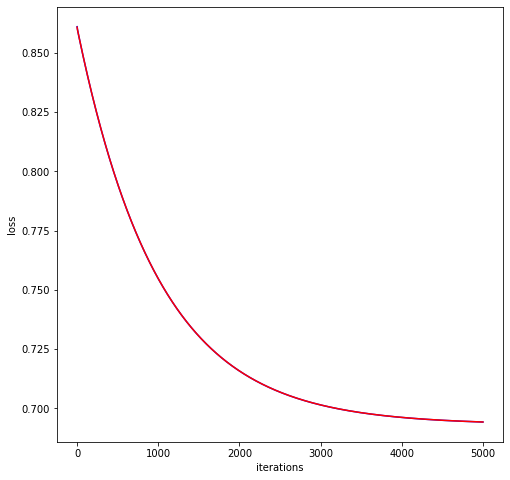

In [31]:
plt.figure(figsize=(8,8))
plt.xlabel("iterations")
plt.ylabel("loss")
plt.plot(iteration, train_loss_list, c='b')
plt.plot(iteration, test_loss_list, c='r')
plt.show()


## 2. Plot the accuracy curve

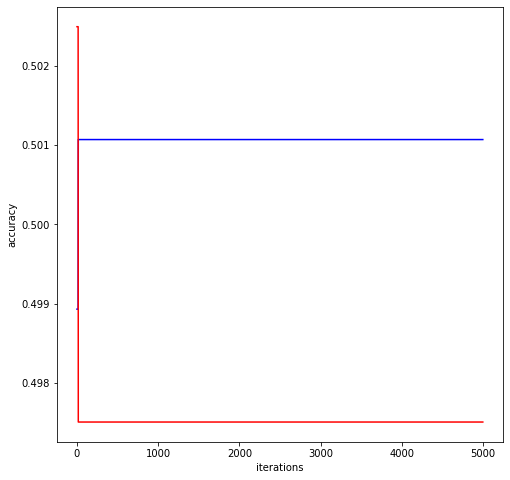

In [32]:
plt.figure(figsize=(8,8))
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.plot(iteration, train_acc_list, c='b')
plt.plot(iteration, test_acc_list, c='r')
plt.show()